# Lab activity : Linear (and other) models for regression

The goal of this activity is to see linear models for regression in practice, and in particular to explore regularization as a means of avoiding overfitting.

A large part of this activity is adapted from M&uuml;ller and Guido, *Introduction to Machine Learning with Python*, pg 33-58.
It also uses ideas from Aur&eacute;lien G&eacute;ron, *Hands-On Machine Learning with Scikit-Learn & TensorFlow*, pg 107-136. 

There is not very much code that you are asked to come up with. Instead you are encouraged to try out variations on the demonstrated code as you go along.

In [2]:
from random import random, gauss
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# 1. Data

First we need some data. Later in this activity we'll use real data, but it's easier to comprehend the principles
using artificial data. The following function produces linear-ish data.

The parameters m and b indicate the slope and y-intercept of the line that the randomly generated data points are near. (I am using high-school algebra variables *m* and *b* for the sake of familiarity). The other parameters allow us to indicate the number of data points (samples) generated, the range that the *x* values come from (0 to 100 by default), and the *standard deviation* std. 

Here's why we include a standard deviation parameter. We don't want our data to be exactly on the line $y = mx + b$, but rather we want the points to be randomly scattered around the line. This is like "noise" in real data. So for every data point, we add a randomly generated error. The error is normally distributed with mean 0 and the given standard deviation. We use the Python library function `random.gauss` for this. Moreover, the $x$ values are actually length-one vectors, not scalars. This is to be consistent with higher-dimensional data.

Make sure you understand everything that is going on in this function.

In [3]:
def linear_data(m, b, samples=50, start=0., stop=100., std=1) :
    rng = stop-start
    xs = np.array([random() * rng + start for i in range(samples)])
    ys = np.array([x * m + b + gauss(0, std) for x in xs])
    return (xs,ys)

The next cell generates data using the function above, stores it in variables for the $x$ and $y$ values, and displays the data. The $x$-axis is labeled "Feature" because that $x$ value is the only feature of that observation/datapoint.

The data is based on the line $y(x) = 1.5 x + 5$. You may modify the parameters to `linear_data` to generate different-looking data, such as with a different line or number of data points, etc. But you'll need to keep `std` pretty large to make sure the data is interesting for our purposes. Also, if you change the number of samples, the slope, or the intercept, you'll need to remember that you made that change and make appropriate adjustments in the code later in this notebook.

Text(0, 0.5, 'Target')

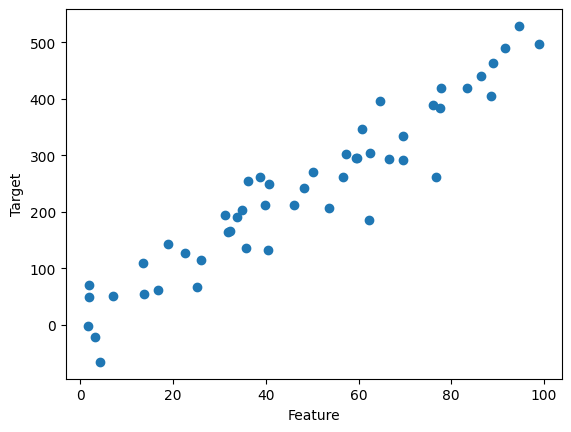

In [4]:
(X,y) = linear_data(5,1.5, std=50)
plt.plot(X, y, 'o')
plt.plot
plt.xlabel("Feature")
plt.ylabel("Target")

Imagine that this is data that we have recorded from some real-world phenomenon. Let's split it into training and test data. The accompanying plot shows training and test points in different colors.

Text(0, 0.5, 'Target')

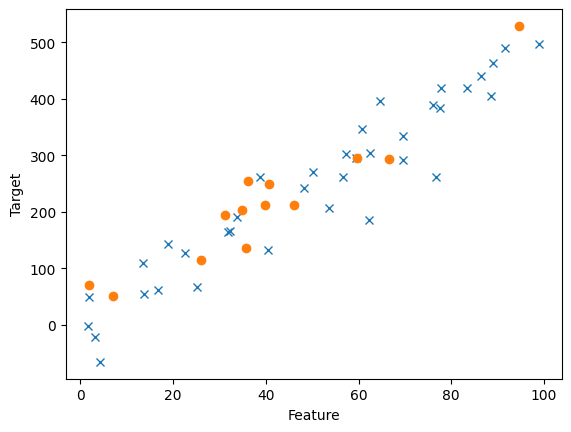

In [5]:
X = X.reshape(-1,1)  # Make our x values to be an array of length-one vectors rather than scalars

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)


plt.plot(X_train, y_train, 'x')
plt.plot(X_test, y_test, 'o')
plt.xlabel("Feature")
plt.ylabel("Target")

## 2. Regression

Before we explore linear regression in particular, let's think about regression more generally. We want a model that predicts a continuous function. Even though K nearest neighbors is usually used as a classifier, we can adapt it for regression: Given an input $x$, we compute the $y$ value that is the average of the $y$ values of the $K$ training points whose $x$ value is closes to the input.

The `KNeighborsRegressor` class from `sklearn.neighbors` does this.

In [17]:
from sklearn.neighbors import KNeighborsRegressor

# insta/ntiate the model and set the number of neighbors to consider to 3
knn_reg = KNeighborsRegressor(n_neighbors=3)

# fit the model using the training data and training targets
knn_reg.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

Let's look at the function modeled by this `KNeighborsRegressor`.

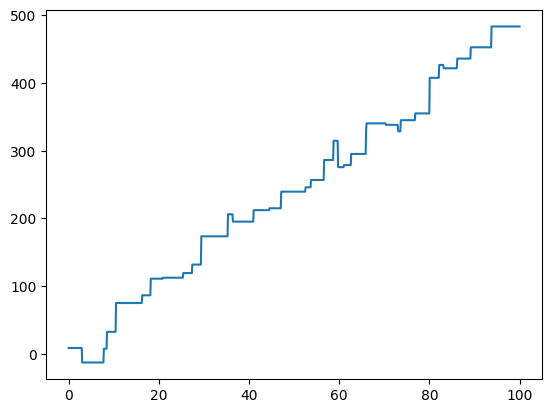

In [18]:
# If your x data doesn't range from 0 to 100, you'll need to change the next line,
# as well as code in certain cells below where the range is hard-wired.
line = np.linspace(0, 100, 1000).reshape(-1, 1)

plt.plot(line, knn_reg.predict(line))


Pretty choppy. Let's measure how well it predicts the test set by comparing the regressor's predictions with the actual values of the test set and computing the $R^2$, which is a measure of goodness of fit, from $0%$ to $100%$.

In [10]:
print("Test set targets:\n", y_test)
print("Test set predictions:\n", knn_reg.predict(X_test))
print("Test set R^2: {:.2f}".format(knn_reg.score(X_test, y_test)))

Test set targets:
 [292.72618431 194.57843868 115.04073827 528.7593369  135.66534501
  70.98940829 203.49693906 253.92126688 294.59228369 248.80564763
  50.25061375 212.20788997 212.57900469]
Test set predictions:
 [340.28877641 173.71038496 119.54653875 483.19270905 206.18913994
   9.01168354 173.71038496 206.18913994 314.5457666  195.37426252
 -12.34654237 215.06985828 195.37426252]
Test set R^2: 0.86


What does the $R^2$ test mean? Let $y_0, \ldots, y_{N-1}$ be the actual target values, $y(\mathbf{x}_0), \ldots, y(\mathbf{x}_{n-1})$ be the predicted
target values, and $\bar{y}$ be the average target value. Then $R^2$ is computed as one minus the sum of the squares of differences between the actual targets and computed targets over the sum of the squares of the differences between actual targets and the mean target:

$$R^2 = 1 - \frac{\sum (y_i - y(\mathbf{x}_i))^2}{\sum (y_i - \bar{y})}$$

A perfect $R^2$ score would be 1, because the differences between actual and computed targets would all be 0. If a model simply outputted $\bar{y}$ for every input, then the $R^2$ would be 0 since the numerator and denominator would be identical.
A *negative* $R^2$ score indicates that the model is even worse than always outputting the mean value.

Using an $R^2$ test here is gratuitous since the data we're using is artificial and has deliberate noise to begin with. Depending on what data you generated, the $R^2$ scores can be across the board.

Let's try this with different numbers of neighbors, and plot the training and test points as well. (This code is particularly indebted to M&uuml;ller and Guido.)

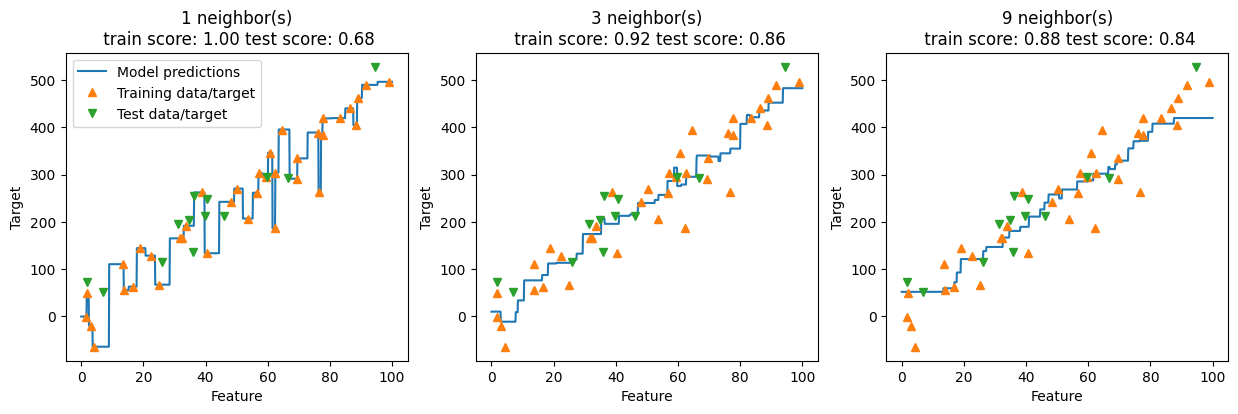

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

line = np.linspace(0, 100, 1000).reshape(-1, 1)
for n_neighbors, ax in zip([1, 3, 9], axes):
    # make predictions using 1, 3, or 9 neighbors
    knn_reg = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn_reg.fit(X_train, y_train)
    ax.plot(line, knn_reg.predict(line))
    ax.plot(X_train, y_train, '^')
    ax.plot(X_test, y_test, 'v')

    ax.set_title(
        "{} neighbor(s)\n train score: {:.2f} test score: {:.2f}".format(
            n_neighbors, knn_reg.score(X_train, y_train),
            knn_reg.score(X_test, y_test)))
    ax.set_xlabel("Feature")
    ax.set_ylabel("Target")
axes[0].legend(["Model predictions", "Training data/target",
                "Test data/target"], loc="best")

Explain what you see in the case of one neighbor. Why is the $R^2$ score $100\%$ on the training data? (Notice that the $R^2$ score of the training data is *not* $100\%$ for larger $K$.)

What do you observe as the number of neighbors becomes large?

## 3. Fit a line

Now let's compare what we saw above with what we have been learning about in class. How how well does simple linear regression model this data? 

Scikit-learn's `LinearRegression` class can be used to fit a line. In the code below, we feed the training data into it and inspect the resulting "coefficient" (the slope $m$ of the line $m x + b$, and so it's the coefficient
of $x$) and intercept

In [12]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
print("lr.coef_:", lr.coef_)
print("lr.intercept_:", lr.intercept_)

lr.coef_: [4.99714797]
lr.intercept_: -6.65831043357494


We happen to know the slope and y-intercept of the line that this randomly generated data was based on. Unless you changed it earlier, $m=5$ and $b=1.5$. Let's plot the data points, the "generating" line, and the line found by Scikit learn.

Text(0, 0.5, 'Target')

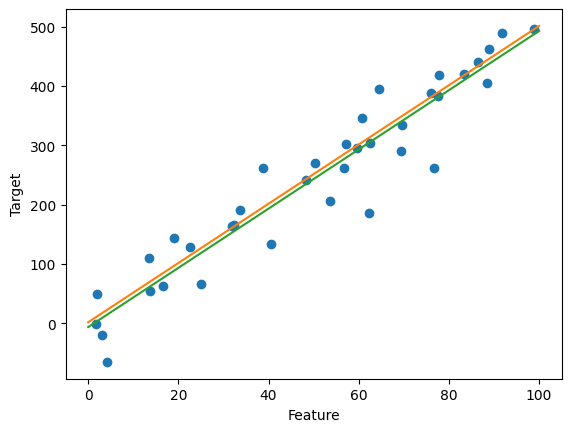

In [13]:
plt.plot(X_train, y_train, 'o')
line = np.linspace(0, 100, 1000).reshape(-1, 1)
plt.plot(line, 5 * line + 1.5)
plt.plot(line, lr.predict(line))
plt.xlabel("Feature")
plt.ylabel("Target")

Remember that it's not as though one line is "correct" and the other is an estimate. Rather, one line was used to generate the random data, and the other is the line that best fits the data that was generated.

To reinforce the idea of $R^2$ score, let's compute that score for the test data against the fitted line.

In [14]:
print("Test set targets:\n", y_test)
print("Test set predictions:\n", lr.predict(X_test))
print("Test set R^2: {:.2f}".format(lr.score(X_test, y_test)))

Test set targets:
 [292.72618431 194.57843868 115.04073827 528.7593369  135.66534501
  70.98940829 203.49693906 253.92126688 294.59228369 248.80564763
  50.25061375 212.20788997 212.57900469]
Test set predictions:
 [326.45794216 149.43267358 123.52288576 465.57058935 172.38361859
   2.53063501 167.42199897 174.5168242  291.8034512  196.24870845
  27.99970308 223.54869314 191.92325773]
Test set R^2: 0.86


Here's a plot showing the test data along with both the generating line and the fitted line.

Text(0, 0.5, 'Target')

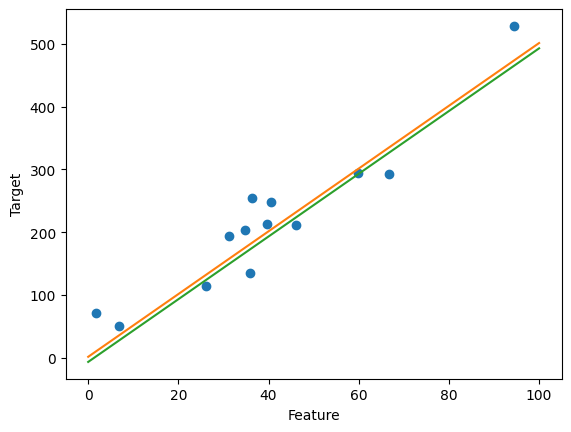

In [15]:
plt.plot(X_test, y_test, 'o')
line = np.linspace(0, 100, 1000).reshape(-1, 1)
plt.plot(line, 5 * line + 1.5)
plt.plot(line, lr.predict(line))
plt.xlabel("Feature")
plt.ylabel("Target")

Now let's turn our attention to real data. One place where we can observe a linear relationship between two variables in economics is the interaction between changes in employment and changes in gross domestic product. Specifically, Okun's law predicts that an increase in unemployment corresponds to a decrease in GDP. To see this, we use a data set recording annual percentage changes to unemployment and GDP in the US. This is from
[a Kaggle notebook posted by Vivek Mhatre](https://www.kaggle.com/code/vmhatre7686/okun-s-law).

In [13]:
empl_gdp = np.loadtxt('/homes/tvandrun/Public/cs381/data/okun.csv', delimiter=',', skiprows=1)  # Read from a CSV file
print(empl_gdp.shape)   # Look at the shape of this array
print(empl_gdp[:3,])   # Look at the first three data points

(68, 3)
[[ 1.948e+03  4.100e+00 -1.000e-01]
 [ 1.949e+03 -5.000e-01  2.100e+00]
 [ 1.950e+03  8.700e+00 -6.000e-01]]


So we have 68 data points, each with 3 features: Year, percent change in real GDP for that year, and change in unemployment rate percentage points. In the first data point, we see that in the year 1948, the GDP increased by 4.1% 
and unemployment decreased by 1 percentage point. 

Now look at all of the values in position 0 of all of the data points.

In [14]:
empl_gdp[:,0]

array([1948., 1949., 1950., 1951., 1952., 1953., 1954., 1955., 1956.,
       1957., 1958., 1959., 1960., 1961., 1962., 1963., 1964., 1965.,
       1966., 1967., 1968., 1969., 1970., 1971., 1972., 1973., 1974.,
       1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982., 1983.,
       1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991., 1992.,
       1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000., 2001.,
       2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010.,
       2011., 2012., 2013., 2014., 2015.])

We see that this data set contains data from 1948 through 2015.

Let's plot these variables against each other: GDP change per year, unemployment change per year, and finally unemployment vs GDP change.

Text(0, 0.5, 'Real GDP change')

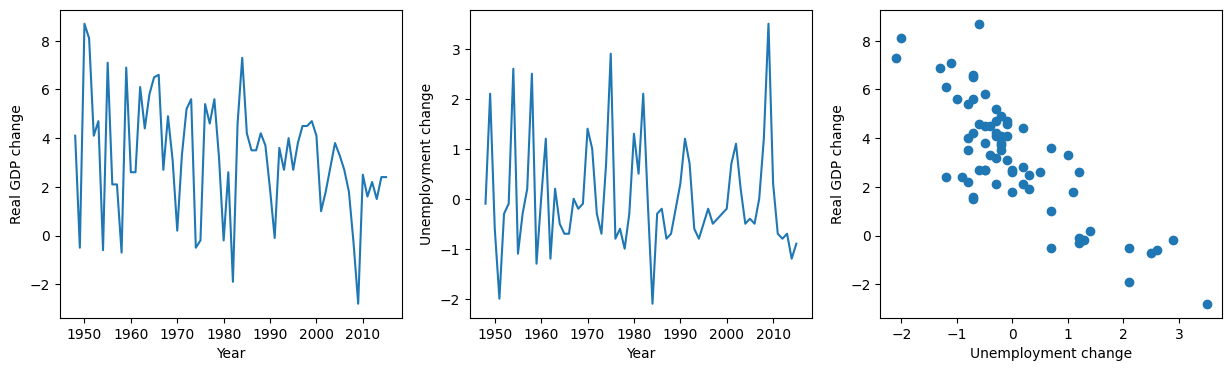

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(empl_gdp[:,0], empl_gdp[:,1])
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Real GDP change')

axes[1].plot(empl_gdp[:,0], empl_gdp[:,2])
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Unemployment change')


axes[2].plot(empl_gdp[:,2], empl_gdp[:,1],'o')
axes[2].set_xlabel('Unemployment change')
axes[2].set_ylabel('Real GDP change')



The last plot does indeed look light a roughly linear relationship. Keep in mind that the dots in the last plot are not in chronological order. Dots from different years are scattered throughout the plot.

Next we make unemployment change and Real GDP change to be our $X$ and $y$ values, and split them into training and test sets.

In [16]:
X_emp = empl_gdp[:,2].reshape(-1,1)
y_gdp = empl_gdp[:,1]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_emp, y_gdp)

Now let's train a linear regressor on the training data; compute the $R^2$ score of the regressor on the test data; and plot the line of the regressor along with the training and test points on the same plot. You can laregely copy and past from earlier cells, but make sure you undertand all the parts and make necessary changes.

Training set score: 0.57
Test set score: 0.82


Text(0, 0.5, 'Real GDP change')

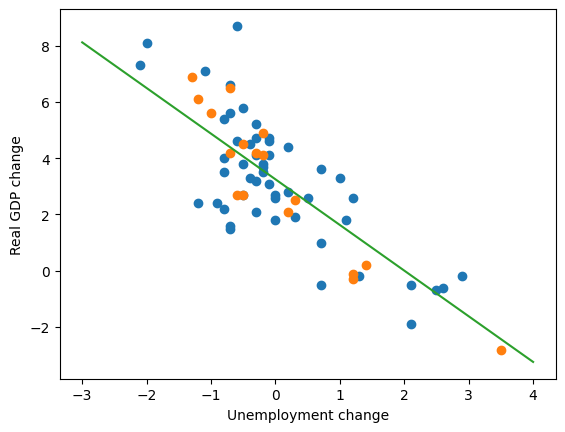

In [18]:

lr = LinearRegression().fit(X_train, y_train)

print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

plt.plot(X_train, y_train, 'o')
plt.plot(X_test, y_test, 'o')
line = np.linspace(-3,4,1000).reshape(-1, 1)
plt.plot(line, lr.predict(line))
plt.xlabel("Unemployment change")
plt.ylabel("Real GDP change")

In the visualization above, the training-set points are blue and the test-set points are orange. 
With data of this (small) size, the $R^2$ score is greatly influenced by which points end up in the training or test set. (To observe this, go back and re-run the train-test-split cell and the cell that fits and scores.) 

Scikit-Learn's `train_test_split` by default puts 75% of the data in the training set and 25% in the test set, but we can fiddle with this proportion using the parameters `test_size` or `train_size` (if you set one, then the other will be automatically set to be the complement of the other). If these parameters are floats, then they are interpreted as percentages; if ints, as absolute number of staples. What happens if we do a 50/50 split? What happens if we have exactly 2 training points? Try each scenario (and others of your choice) below. Remember that `train_test_split` splits the data randomly, so you'll get different results each time you run this. Predict what the test and training scores will be like, and explain the results you get.


Training set score: 0.69
Test set score: 0.55


Text(0, 0.5, 'Real GDP change')

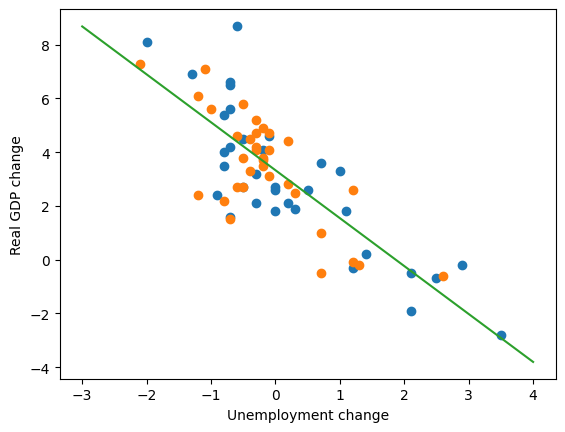

In [19]:
# Fifty-fifty split
X_train, X_test, y_train, y_test = train_test_split(X_emp, y_gdp, test_size=.5)

# Exactly two training points
#X_train, X_test, y_train, y_test = train_test_split(X_emp, y_gdp, train_size=2)

lr = LinearRegression().fit(X_train, y_train)


print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

plt.plot(X_train, y_train, 'o')
plt.plot(X_test, y_test, 'o')
line = np.linspace(-3,4,1000).reshape(-1, 1)
plt.plot(line, lr.predict(line))
plt.xlabel("Unemployment change")
plt.ylabel("Real GDP change")

## 4. Multiple regression

Multiple regression, which really is just short for *multiple linear regression*, applies this idea to data in more than one dimension. Ultimately we want to work with data with a whole bunch of features, but let's start with just two features in order to gain intuition.

### 4.1 Car emissions data set

The following loads a data set for exploring the relationshipt between a car's volume, weight, and CO2 output. (I got this data set
from [a tutorial on W3 Schools](https://www.w3schools.com/python/python_ml_multiple_regression.asp), which I don't consider a reputable source; I don't know whether this data is real or made up, but it will serve for this example.)

It's convenient to load these data sets as Pandas dataframes, though we'll convert the data to numpy arrays when we get down to real work.

In [20]:
cars = pd.read_csv('/homes/tvandrun/Public/cs381/data/car_emissions.csv')
cars.head()

,Car,Model,Volume,Weight,CO2
0,Toyoty,Aygo,1000,790,99
1,Mitsubishi,Space Star,1200,1160,95
2,Skoda,Citigo,1000,929,95
3,Fiat,500,900,865,90
4,Mini,Cooper,1500,1140,105


We don't care about the make and model, so we'll drop those.

In [21]:
cars = cars.drop(columns=['Car','Model'])
cars.head()

,Volume,Weight,CO2
0,1000,790,99
1,1200,1160,95
2,1000,929,95
3,900,865,90
4,1500,1140,105


We'll take volume and weight as independent variables (the features of the data points) and CO2 as the dependent variable (the target)---that is, we think we can predict CO2 from volume and weight. To visualize this, let's plot each feature against the target. 
(Think through the details of this code. Look up [iloc in the Pandas API for more information](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html#pandas.DataFrame.iloc).) First we plot volume vs CO2:

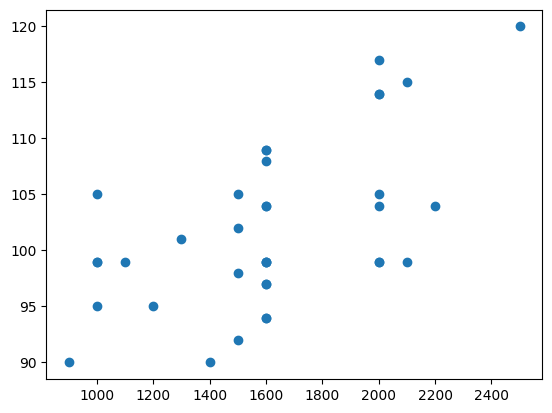

In [22]:
plt.scatter(cars.iloc[:,0], cars.iloc[:,2])

Then weight vs CO2:

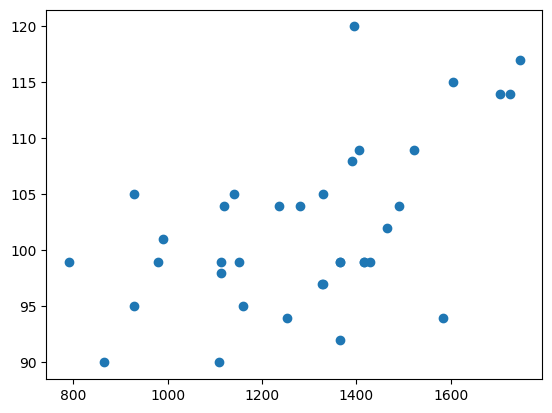

In [23]:
plt.scatter(cars.iloc[:,1], cars.iloc[:,2])  

In either case, the relationship looks *vaguely* linear, but not likely to produce a great predictor on their own. But let's see them in three dimensional space:

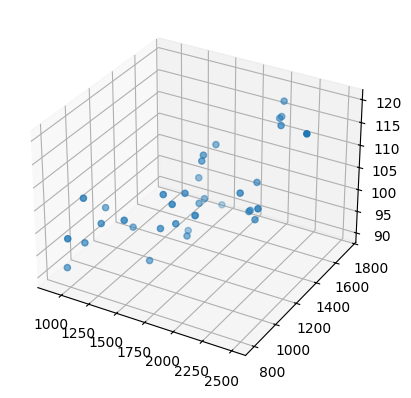

In [24]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cars.iloc[:,0],cars.iloc[:,1],cars.iloc[:,2])


To interpret this, the two horizontal axes are the features and the vertical axis is the target. The idea is that we can learn a place that approximates these points and would be a good predictor of CO2 for other volume, weight readings.

Let's turn the data into numpy arrays. Below, `X_cars` contains data for the first two columns (scaled) and `y_cars' contains the corresponding targets.

In [25]:
from sklearn.preprocessing import MinMaxScaler
X_cars = MinMaxScaler().fit_transform(cars.iloc[:,:-1].to_numpy())
y_cars = cars.iloc[:,-1].to_numpy()
print(X_cars.shape)
print(y_cars.shape)

(36, 2)
(36,)


Thirty-six samples is pretty small, but let's see what results we get.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_cars, y_cars, test_size=.85)
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))


Training set score: 0.44
Test set score: 0.05


Depending on how the training/testing split goes, the score on the training set is between 20 and 100. The test set score could be over a wide range. That's not great, but let's see what the plane that we found looks like.

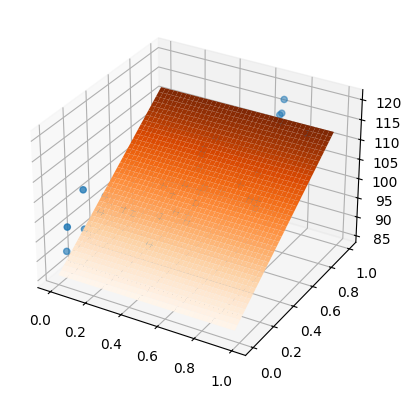

In [27]:
from matplotlib import cm
fig = plt.figure()

# Make the same scatter plot as before for the data
ax = fig.add_subplot(projection='3d')
ax.scatter(X_cars[:,0], X_cars[:,1], y_cars)

# Make a plane by applying the regressor to every point in the two-dimensional range
min0 = min(X_cars[:,0])
min1 = min(X_cars[:,1])
max0 = max(X_cars[:,0])
max1 = max(X_cars[:,1])
range0 = np.arange(min0, max0, .025)
range1 = np.arange(min1, max1, .025)
XX, YY = np.meshgrid(range0, range1)
ZZ = lr.predict(np.array([XX.ravel(), YY.ravel()]).T)
ZZ = ZZ.reshape(XX.shape)
ax.plot_surface(XX, YY, ZZ, cmap=cm.Oranges)


This visualization should give a sense of how the plane is fit to the trends of the points. But now we're going to move on to data sets with many more features, which are harder to visualize.

### 4.2 California housing data set

The California Housing Prices data set is a widely used sample data set that relates a variety of measurements about housing (house size, house age, location, etc) to price. It was collected in 1970. 

In performing multiple linear regression on this data, we are hypothesizing that the price of a house can be predicted from a linear combination of the features of a data point for that home. In other words, we want to find a vector of parameters/weights $\mathbf{\theta}$ such that a predicted price $y$ can be computed for data point $\mathbf{x}$ as

\begin{equation}
y(\mathbf{x}) =  \theta_0 + \theta_{[1..D]}^T \mathbf{x}
\end{equation}

(In the notation above, the vector $\theta$ represents the entire collection of parameters, including the constant term $\theta_0$,
amd $\theta_{[1:D]}$ is the vector containing parameters 1 through $D$, that is, everything except for $\theta_0$. For two vectors $\mathbf{a}$ and $\mathbf{b}$, we write their dot product as $\mathbf{a}^T \mathbf{b}$, which literally means "transpose of $\mathbf{a}$ matrix-multiplied by $\mathbf{a}$".)

Linear regression minimizes the sum of the squares of the errors (if we divide this by the number of data points, we get the *mean square error*):

\begin{equation}
\sum_{n=0}^{N-1} (y_n - y(\mathbf{x}))^2 = \sum_{n=0}^{N-1} (y_n - \theta_0 - \theta_{[1:D]}^T \mathbf{x}_n)^2
\end{equation}

Let's load the data, [which is included in Scikit-Learn](https://scikit-learn.org/1.5/datasets/real_world.html#california-housing-dataset).

In [28]:
from sklearn.datasets import fetch_california_housing
calif = fetch_california_housing()
print("Data shape:", calif.data.shape)

Data shape: (20640, 8)


These Scikit-Learn included data sets are loaded as a numpy `Bunch`, which can be used like a dictionary.

In [29]:
print('Type: ' + str(type(calif)))
print('Keys: ' + str(calif.keys()))

Type: <class 'sklearn.utils._bunch.Bunch'>
Keys: dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])


The key `DESC` (that is, *description*) provides a summary of the data set.

In [30]:
print(calif['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

We care most about the `data` and `target`.

In [31]:
print(calif.data.shape)
print(calif.target.shape)

(20640, 8)
(20640,)


Look at a sample data point:

In [32]:
print(str(calif.data[0]))
print(str(calif.target[0]))

[   8.3252       41.            6.98412698    1.02380952  322.
    2.55555556   37.88       -122.23      ]
4.526


One really cool thing about this data set is that the data points have latitude and longitude, which can be used for plotting. (The house prices, from `calif.target`, are mapped to colors for the points.)

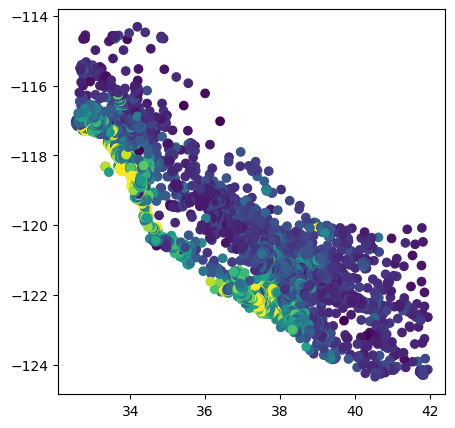

In [33]:
plt.figure(figsize=(5,5))
plt.scatter(calif.data[:,6], calif.data[:,7], c=calif.target)

The various features have very different scales (consider "average number of rooms" vs "longitude"), so we use `MinMaxScaler` to transform the data so that all features are on a range from 0 to 1.

In [34]:
X_calif = MinMaxScaler().fit_transform(calif.data)
print(str(X_calif[0]))

[0.53966842 0.78431373 0.0435123  0.02046866 0.00894083 0.00149943
 0.5674814  0.21115538]


Now we split it into training and test sets and use `LinearRegression` to fit a hyperplane to it and see how well the model performs.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_calif, calif.target)
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.60
Test set score: 0.61


You likely got around .60 for both the training and test set. The scores are pretty stable across differing splits. That's a pretty low score for the training set. Linear regression is probably not the right model for this data (although the story isn't quite over---its is possible that selecting and combining features could reveal a linear relationship).

Let's try a different data set.

### 4.3 Wine quality

The following data set below is from [a site on the UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/186/wine+quality) and allows us to relate readings on various kinds of wines to the quality of the wine.
(There is different, widely used wine data set [available through Scikit-Learn](https://scikit-learn.org/stable/datasets/toy_dataset.html#wine-recognition-dataset), but that data set is more appropriate for classification). Since we have this as a CSV file, we'll use Pandas to load and take a look at it.

In [36]:
wine = pd.read_csv('/homes/tvandrun/Public/cs381/data/winequality-red.csv', sep=';')  # dumb "CSV" file separated using semicolons


Pandas has a variety of tools for getting to know that basics of a data set. Note the differences among the methods 'info', 'describe', and 'head'.

In [37]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [38]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [39]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


The last column, `quality`, is what we take as our target value. Let's take scaled versions of the other columns as the features of our data set.

In [40]:
X_wine = MinMaxScaler().fit_transform(wine.iloc[:,:-1].to_numpy())
y_wine = wine.iloc[:,-1].to_numpy()

In [41]:
X_wine[:5]

array([[0.24778761, 0.39726027, 0.        , 0.06849315, 0.10684474,
        0.14084507, 0.09893993, 0.56754772, 0.60629921, 0.13772455,
        0.15384615],
       [0.28318584, 0.52054795, 0.        , 0.11643836, 0.14357262,
        0.33802817, 0.2155477 , 0.49412628, 0.36220472, 0.20958084,
        0.21538462],
       [0.28318584, 0.43835616, 0.04      , 0.09589041, 0.13355593,
        0.1971831 , 0.16961131, 0.50881057, 0.40944882, 0.19161677,
        0.21538462],
       [0.5840708 , 0.10958904, 0.56      , 0.06849315, 0.10517529,
        0.22535211, 0.19081272, 0.58223201, 0.33070866, 0.1497006 ,
        0.21538462],
       [0.24778761, 0.39726027, 0.        , 0.06849315, 0.10684474,
        0.14084507, 0.09893993, 0.56754772, 0.60629921, 0.13772455,
        0.15384615]])

In [42]:
y_wine[:5]

array([5, 5, 5, 6, 5])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine)
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.36
Test set score: 0.36


This is also not impressive. Let's try one more

### 4.4 Medical costs

This data set, [available through Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance), relates information about a person to medical costs billed by their health insurance. Some of the features are *categorical*: `sex` has values `male` and `female`,
`smoker` has values `yes` and `no`, and `region` is determined by splitting the country into quadrants (`southwest` etc). 
The `converters` parameter to `pd.read_csv` maps feature names to functions that convert from categorical data to numerical data (the numerical interpretation of `region` was arbitrary).



In [44]:
insurance = pd.read_csv('/homes/tvandrun/Public/cs381/data/insurance.csv', converters={'sex':lambda x: 0. if x == 'male' else 1., 'smoker':lambda x : 0. if x == 'yes' else 1.,
                                                    'region':lambda x: -1.0 if x == 'southwest' else -.5 if x == 'southeast' else .5 if x == 'northwest' else 1.0})


In [45]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   float64
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   float64
 5   region    1338 non-null   float64
 6   charges   1338 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 73.3 KB


In [46]:
insurance.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.494768,30.663397,1.094918,0.795217,-0.015321,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,0.783590,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,-1.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,1.000000,-0.500000,4740.287150
50%,39.000000,0.000000,30.400000,1.000000,1.000000,-0.500000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,1.000000,0.500000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,1.000000,63770.428010


In [47]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1.0,27.900,0,0.0,-1.0,16884.92400
1,18,0.0,33.770,1,1.0,-0.5,1725.55230
2,28,0.0,33.000,3,1.0,-0.5,4449.46200
3,33,0.0,22.705,0,1.0,0.5,21984.47061
4,32,0.0,28.880,0,1.0,0.5,3866.85520


You know the routine by now. Observe (and experiment for yourself).

In [48]:
X_ins = MinMaxScaler().fit_transform(insurance.iloc[:,:-1].to_numpy())
y_ins = insurance.iloc[:,-1].to_numpy()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_ins, y_ins)
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.76
Test set score: 0.73


## 5. Polynomial regression

The natural next question is how to improve multiple regression. Let's consider our options on how to vary it. *Polynomial regression*, which we look at in this section, seems at first to be an inherently different thing from *linear* regression, but what we'll see is that it really is a specific application of multiple regression.

Suppose we have data in two variables from a phenomenon that we suspect can be modeled with a polynomial. The following function produces artificial polynomial-ish data plus noise, like our `linear_data` function above. The polynomial function that we are generating noisy data around is represented by an array of coefficients. This is a generalization of the `m` and `b` parameters to `linear_data`.

In [50]:
def poly_data(coefs, samples=50, start=0., stop=100., std=500) :
    rng = stop-start
    xs = np.array([random() * rng + start for i in range(samples)])
    ys = np.array([sum([coefs[i]*(x**i) for i in range(len(coefs))]) + gauss(0, std) for x in xs])
    return (xs,ys)

For convenience, the following makes a [vectorized function](https://numpy.org/doc/2.1/reference/generated/numpy.vectorize.html#numpy-vectorize) from a set of coefficiences so that we can model and plot the "real" polynomial function that the data was generated from.

In [51]:
def poly_fun(coefs) :
    return np.vectorize(lambda x : sum([coefs[i]*(x**i) for i in range(len(coefs))]))

Let's generate some data around a polynomial and see how it looks compared with the polynomial used to generate it.

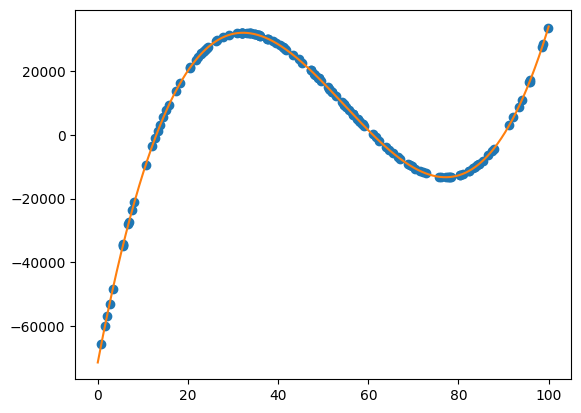

In [52]:
# I played around until I found a cubic function that looked good in the range [0, 100]
coefs = [-71370., 7453., -164.,1.]
# The "real" function
polynom = poly_fun(coefs)
# The artificial noisy data
X, y = poly_data(coefs,samples=150,std=00000)
X = X.reshape(-1,1) 

# Display them
line = np.linspace(0, 100, 1000).reshape(-1, 1)
plt.plot(X, y,'o')
plt.plot(line, polynom(line))


Now we want to use regression to find a polynomial that best fits the data. But---and here-s the important point---polynomial regression isn't really a different thing from linear regression. Rather, we take each (scalar) $x$ value and compute its *polynomial features*, which is the vector $[1, x, x^2, x^3, \ldots]$, up to whatever degree polynomial we hypothesize for the model. Then we can use those vectors as the data points in multiple regression. 

Let's see what polynomial features look like.

In [53]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures


X_poly = PolynomialFeatures(degree=3).fit_transform(X)
# Display the first five original (scalar) x values
print(X[:5])
# Display the polynomial features of the first five x values
print(X_poly[:5])

[[82.38943985]
 [38.89156106]
 [31.76401457]
 [67.07136646]
 [33.07633031]]
[[1.00000000e+00 8.23894399e+01 6.78801980e+03 5.59261149e+05]
 [1.00000000e+00 3.88915611e+01 1.51255352e+03 5.88255677e+04]
 [1.00000000e+00 3.17640146e+01 1.00895262e+03 3.20483858e+04]
 [1.00000000e+00 6.70713665e+01 4.49856820e+03 3.01725116e+05]
 [1.00000000e+00 3.30763303e+01 1.09404363e+03 3.61869484e+04]]


Now we can just apply linear regression as before.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y)
lr_poly = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr_poly.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr_poly.score(X_test, y_test)))

Training set score: 1.00
Test set score: 1.00


What does this regressor look like compared with the polynomial we used to generate the data?

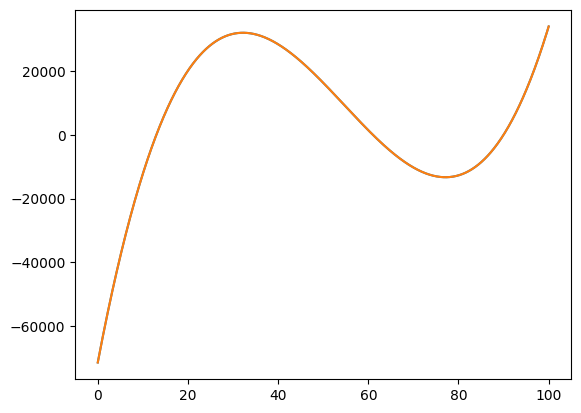

In [55]:
# Display them
line = np.linspace(0, 100, 1000).reshape(-1, 1)
line_poly = PolynomialFeatures(degree=3).fit_transform(line)
plt.plot(line, polynom(line))
plt.plot(line, lr_poly.predict(line_poly))

Before going on, **rerun the previous four steps** but with a larger standard deviation for generating noise in the data.

We can use polynomial features to explore interactions between features in a data set. The following uses the California housing data set and turns the 8 features into 44 features by computing the products of distinct pairs of features. 

In [56]:
print(str(calif.data.shape))
X_calif_poly = (PolynomialFeatures(degree=2, include_bias=False).fit_transform(MinMaxScaler().fit_transform(calif.data)))
X_train, X_test, y_train, y_test = train_test_split(X_calif_poly, calif.target)
print(str(X.shape))
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

(20640, 8)
(150, 1)
Training set score: 0.68
Test set score: 0.67


The score on the training set shows a modest improvement; the test set score varies a lot based on the train-test split.

We'd like to experiment with different data sets and degrees, so let's write a function to pack up the steps in 
transforming data into polynomial features, doing a train/test split, doing linear regression, and then reporting the scores.

In [57]:
def linear_regression_polyn_features(X, y, deg=2) :
    # Show the original shape
    print(str(X.shape))
    X_p = (PolynomialFeatures(degree=deg, include_bias=False).fit_transform(MinMaxScaler().fit_transform(X)))
    # Show the shape of the data set with polynomial features
    print(str(X_p.shape))
    X_train, X_test, y_train, y_test = train_test_split(X_p, y)
    lr = LinearRegression().fit(X_train, y_train)
    # Show the training and test set scores
    print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
    print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Here are a few cells with some ready-made experiments. Try varying these and seeing what happens.

In [58]:
linear_regression_polyn_features(calif.data, calif.target, 1)

(20640, 8)
(20640, 8)
Training set score: 0.60
Test set score: 0.61


In [60]:
linear_regression_polyn_features(X_cars, y_cars, 1)

(36, 2)
(36, 2)
Training set score: 0.44
Test set score: -0.46


In [61]:
linear_regression_polyn_features(X_wine, y_wine, 1)

(1599, 11)
(1599, 11)
Training set score: 0.34
Test set score: 0.41


In [62]:
linear_regression_polyn_features(X_ins, y_ins, 2)

(1338, 6)
(1338, 27)
Training set score: 0.85
Test set score: 0.82


## 6. Regression with regularization

For the last leg of this lab, we use the insurance data set with polynomial features of degree 5 as our running example. I'm picking this because it gives us a very high training test score and a modest test set score.


In [63]:
X_ins_poly = PolynomialFeatures(degree=5, include_bias=False).fit_transform(MinMaxScaler().fit_transform(X_ins))

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_ins_poly, y_ins)
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.89
Test set score: 0.62


That difference---consistently better score on the training set---is what we call *overfitting*.
Linear regression, in fact, is particularly prone to overfitting. We can reduce overfitting by *regularization*, which, as we'll see in class, changes the loss function in a way that penalizes the complexity of the model.

### 6.1 Ridge regression

*Ridge regression* restricts the model by subtracting the Euclidean distance of the coefficient array $\mathbf{\theta}$ as a penalty term to the loss function. Thus ridge regression minimizes

\begin{equation}
\sum_{n=0}^{N-1} (y_n - \theta_0 - \theta_{[1..D]}^T \mathbf{x})^2 + \alpha || \Theta ||_2
\end{equation}

The hyperparameter $\alpha$ determines how much weight to give to the penalty (or *regularization* term.
If we set $\alpha = 0$, we would get plain old linear regression. A large $\alpha$ makes the line or hyperplane flatter and closer to the mean of the data.

(This next cell uses the same test/train split as the previous cell, so make sure that the previous cell is the most recent one executed; moreover, if you want to run this experiment again with a different split, re-run *both* the previous cell and the next one. The intent is that you compare the results of the next cell with the previous one.)

In [65]:
from sklearn.linear_model import Ridge

print("Ridge regression")
ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

Ridge regression
Training set score: 0.85
Test set score: 0.83


M&uuml;ller and Guido say (although they were using to a different data set),

>As you can see, the training set score of `Ridge` is *lower* than for `LinearRegression` while the test score is *higher*... WIth linear regression, we are overfitting our data. `Ridge` is a more restricted model, so we are less likely to overfit. (Pg 51)

Depending on how your data was split, your test score might not be higher than the training score, as the quote above suggests; but the training and test scores are probably pretty close.

The $\alpha$ parameter is a lever for controlling how restricted the model is. The code above used scikit-learn's default value of $\alpha=1$. Try increase or decreasing it:

In [83]:
ridge100 = Ridge(alpha=100).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge100.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge100.score(X_test, y_test)))

Training set score: 0.76
Test set score: 0.76


In [84]:
ridge01 = Ridge(alpha=0.01).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge01.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge01.score(X_test, y_test)))

Training set score: 0.87
Test set score: 0.80


Discuss with your partner what you observe. (Use words like "overfit" and "generalize".)

To see what ridge regression is actually doing, it helps to inspect the parameters of the resulting model. What does 
the parameter vector $\mathbf{\theta}$ look like? We can see this by looking at the `coef_` instance variable of the objects representing these models. Note that `lr`, `ridge`, etc, are isntances of classes, and they have an instance variable `coef_` that is a numpy array.



In [85]:
print(type(lr))
print(type(lr.coef_))
print(lr.coef_.shape)

<class 'sklearn.linear_model._base.LinearRegression'>
<class 'numpy.ndarray'>
(461,)


Test your understanding: Why does `lr.coef_` have length 461?

Now let's look at the first 10 elements of these parameter vectors.

In [86]:
print(lr.coef_[:10])
print(ridge.coef_[:10])
print(ridge100.coef_[:10])
print(ridge01.coef_[:10])

[-133536.85526647   -6361.51164513 -791816.92504843 -181979.99690483
  -17807.36015882   91555.15250151 -187763.19950155   36496.87367154
 1106352.43488741  468182.96704093]
[ 4084.69856426  -880.2648311  24199.94837064 -1667.51288945
 -2435.68880104 -2786.08812512  4014.58601238  -438.45209327
  7356.41336237 -1371.61964566]
[ 1844.47946733  -266.59276388  2295.19223028   438.34486968
 -3343.70348894    91.90928003  1615.51400831   213.24887724
  1605.52073437   446.67809929]
[ 23696.18082596   2510.53425717  54991.39479596   -177.63130766
    377.90332405  -8172.73953724  -7659.40549024  -2637.76305014
  -3216.18551324 -13993.43380554]


What are those numbers telling us?
Well, let's visualize them.
In the following graph the indices of the parameters are along the x-axis and the value of the parameters
are the y values. 

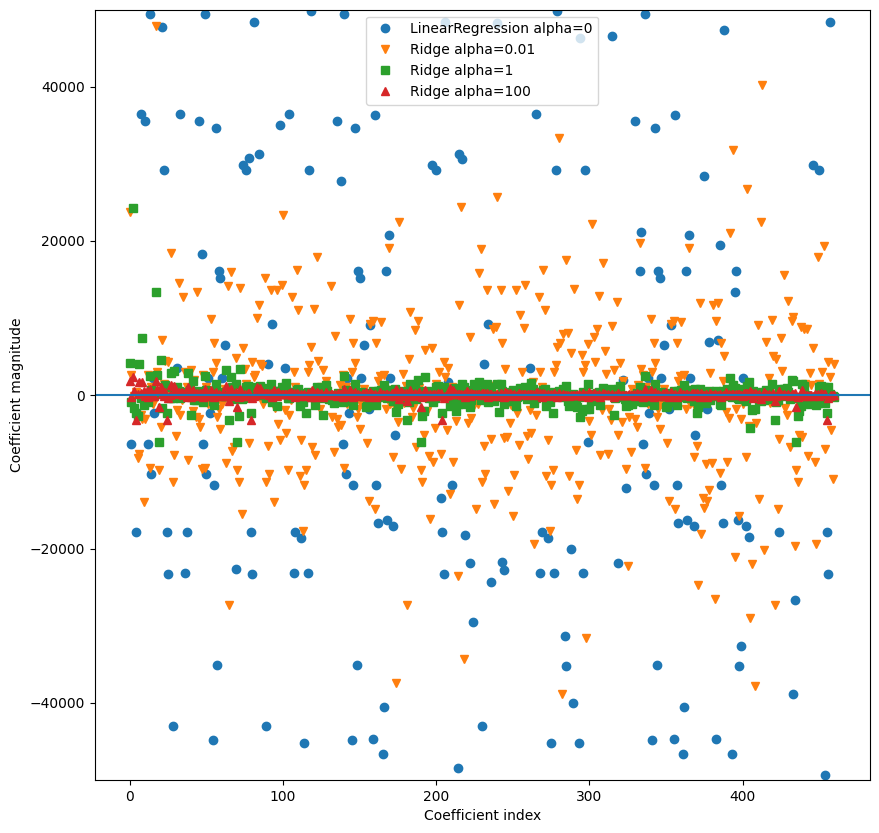

In [87]:
# Modify this to change the physical dimensions of the plot
plt.figure(figsize=(10,10))

plt.plot(lr.coef_, 'o', label="LinearRegression alpha=0")
plt.plot(ridge01.coef_, 'v', label="Ridge alpha=0.01")
plt.plot(ridge.coef_, 's', label="Ridge alpha=1")
plt.plot(ridge100.coef_, '^', label="Ridge alpha=100")

plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)

# Modify this to change the range of y values, that is, to zoom in or out around the x-axis
plt.ylim(-50000,50000)
plt.legend()

Higher values of $\alpha$ result in a smaller magnitude for the coefficients. As M&uuml;ller and Guido put it,

> The x-axis enumerates the entries of `coef_`. Thus `x=0` shows the coefficient associated 
> with the first feature, `x=1` the coefficient associated with the second feature, up to 
>`x=100`. The y-axis shows the numeric values of the corresponding values of the coefficients. 
>The main takeaway here is that for `alpha=10`, the coefficients are mostly between around -3 
>and 3. The coefficients for the `Ridge` model with `alpha=1` are somewhat larger. The dots 
>corresponding to `alpha=0.1` have larger magnitude still, and many of the dots corresponding 
>to linear regression without any regularization (which would be `alpha=0`) are so large they 
>are outside of the chart. (Pg 53)



### 6.2. LASSO regularization

An alternative to regression with ridge regularization is *LASSO*. The name comes from *least absolute shrinkage and selection operator*. The difference from ridge is that it uses the L1 norm intead of L2---that is, it uses Manhattan distance instead of Euclidean distance. As a result, some coefficients are zero, and the corresponding attributes are ignored.

In [88]:
from sklearn.linear_model import Lasso


lasso = Lasso(max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

Training set score: 0.86
Test set score: 0.83
Number of features used: 116


As with ridge regression, the training set score decreased and the test set score increased. But here's what's going on: The "numer of features used" means the number of non-zero coefficients. The rest of the 461 features are simply ignored. Thus LASSO works as a feature selection tool (refer again to what the name LASSO means).

The `max_iter` parameter is there because LASSO isn't solved from a closed formula but rather is found by an iterative algorithm like gradient descent, which we'll see in class later this semester. As the parameter name suggests, this allows us to control the maximum iterations the algorithm should use before quitting, to avoid getting stuck in a position where indefinite, insignificant improvements keep being made.

As with ridge regression, we can fiddle with the hyperparameter $\alpha$. (These next cells might take a while.)

In [89]:
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

Training set score: 0.89
Test set score: 0.78
Number of features used: 415


/penv/lib64/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.513e+09, tolerance: 1.524e+07
  model = cd_fast.enet_coordinate_descent(


That's better. What if we set $\alpha$ really low?

In [96]:
lasso00001 = Lasso(alpha=0.0001, max_iter=100).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso00001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso00001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso00001.coef_ != 0))

Training set score: 0.87
Test set score: 0.82
Number of features used: 461


/penv/lib64/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.024e+10, tolerance: 1.524e+07
  model = cd_fast.enet_coordinate_descent(


 Let's compare the coeffient magnitudes for different values of $\alpha$, with the best ridge model ($\alpha = 0.1$) for another point of comparison:

Text(0, 0.5, 'Coefficient magnitude')

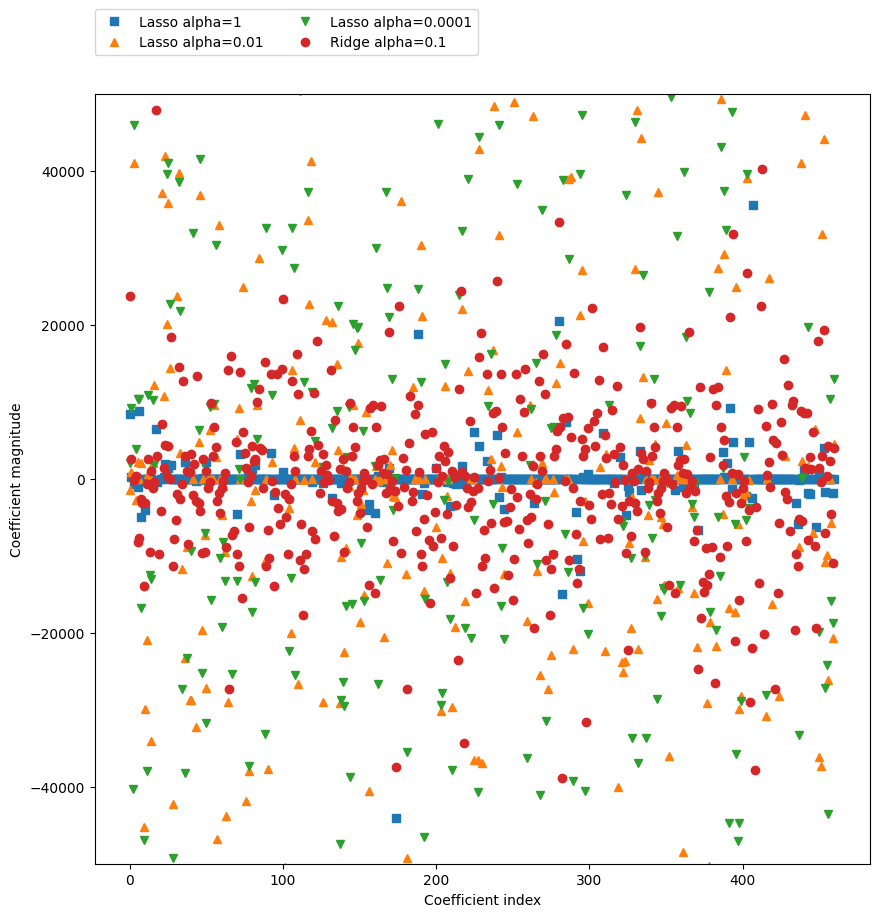

In [92]:
# Modify this to change the physical dimensions of the plot
plt.figure(figsize=(10,10))

plt.plot(lasso.coef_, 's', label="Lasso alpha=1")
plt.plot(lasso001.coef_, '^', label="Lasso alpha=0.01")
plt.plot(lasso00001.coef_, 'v', label="Lasso alpha=0.0001")

plt.plot(ridge01.coef_, 'o', label="Ridge alpha=0.1")
plt.legend(ncol=2, loc=(0, 1.05))

# Modify this to change the range of y values, that is, to zoom in or out around the x-axis
plt.ylim(-50000,50000)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")

What do you observe?

In [94]:
nah
---------------
| ____  _____ |
|  <O>   <o>  |
|      \ \    |
|       \_\   |
|    /"""""\  |
|    -------  |
|    \_____/  |
 \____________/
      \|/
       |
      / \


SyntaxError: invalid syntax (1034786929.py, line 2)